# GAPF for the UCI Credit Card Data Set

In [1]:
import torch
import torch.utils.data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing


device = torch.device('cpu')

### Import the UCI Credit Card Dataset

The goal of GAPF in this scenario is to decorrelate the original data from the sex each person is associated with. Ideally data scientists would still be able to learn models to predict y without being able to predict s.

In [2]:
import os
import shutil

datadir = './data'
if not os.path.exists(datadir):
    os.makedirs(datadir)

In [3]:
# Get the dataset from UCI

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls' 
filename = os.path.join(datadir, 'default of credit card clients.xls')

if not os.path.isfile(filename):
    wget.download(url, out=filename)

**Clean up**

In [4]:
df = pd.read_excel(filename, header=1)
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df['target'] = df['default payment next month'].astype('category')

df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month', 'target'],
      dtype='object')

In [5]:
X = df.drop(['default payment next month', 'target'], axis=1)

In [6]:
encoders = {}
X_num = X.copy()

label_cols = ['sex', 'education', 'marriage', 'age', 'target']

for col in X_num.columns.tolist():
    if col in label_cols:
        encoders[col] = preprocessing.LabelEncoder().fit(X_num[col])
        X_num[col] = encoders[col].transform(X_num[col])
X_num = X_num.drop(['sex'], axis=1)

y = df['target'].copy()
s = encoders['sex'].transform(X['sex'])


# Visualizations

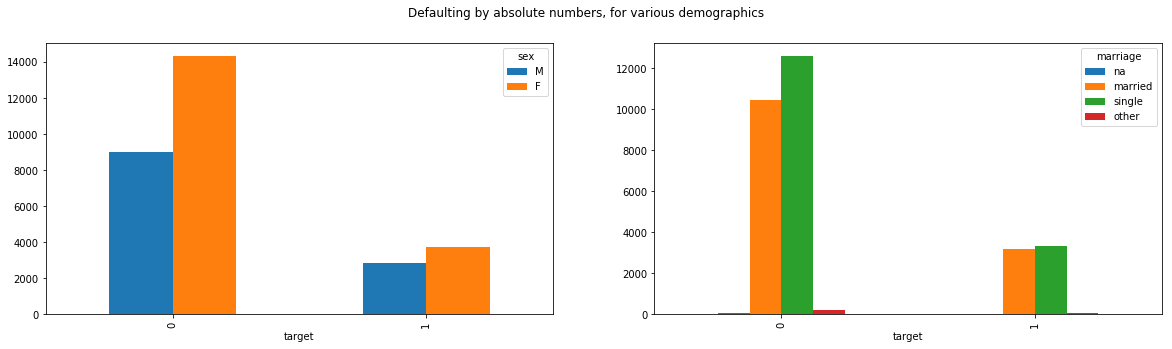

In [7]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])
# df['education'] = df['education'].astype('category').cat.rename_categories(['na', 'graduate school', 'university', 'high school', 'other', 'other2'])

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

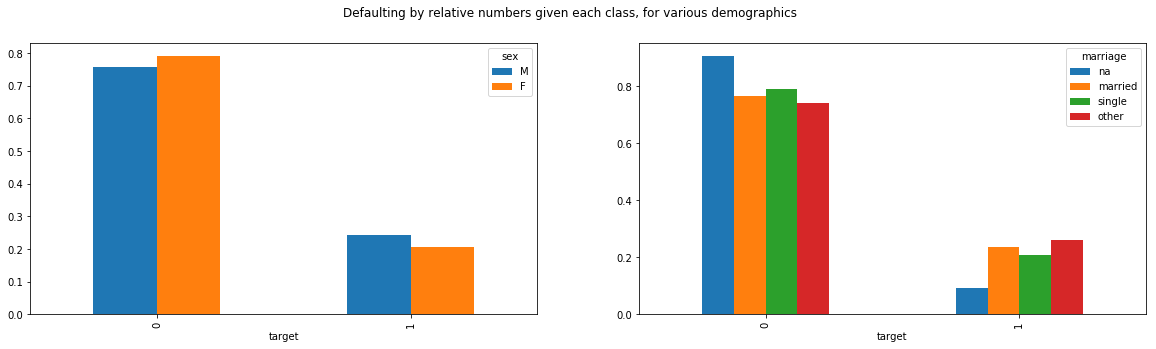

In [8]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

## Create Tensors

In [9]:
X_tensor = torch.tensor(X_num.values, device=device).double()
noise = torch.randn([X_tensor.shape[0], 5], device=device).double()
X_noised = torch.cat((X_tensor, noise), 1)

s_tensor = torch.tensor(s, device=device).double().unsqueeze(1)
y_tensor = torch.tensor(y.values, device=device).double().unsqueeze(1)
print("X", X_tensor.shape, "X_noised", X_noised.shape, "s", s.shape, "y", y.shape)

X torch.Size([30000, 22]) X_noised torch.Size([30000, 27]) s (30000,) y (30000,)


## Create Models

The GAPF model consists of two primary adversarial models.

The generator takes in the original data with an extra 100D tensor of noise, and outputs a tensor the size of the original data.

The adversary takes in the output of the generator and outputs the sensitive attribute.

Finally, we create a classifier that tries to predict the motion from the decorrelated data, to test that the data is still usable.

<img src="./project_webpage/images/gapf.png"></img>

In [10]:
SIZE_1 = 256
SIZE_2 = 128

dim_with_noise = 27
dim = 22

model_gen = torch.nn.Sequential(
          # Layer 1 - 28 -> 512
          torch.nn.Linear(dim_with_noise, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 2 - 512 -> 512
          torch.nn.Linear(SIZE_1, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 3 - 512 -> 512
          torch.nn.Linear(SIZE_1, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Output
          torch.nn.Linear(SIZE_1, dim),
        ).to(device)

model_adv = torch.nn.Sequential(
          # Layer 1 - 23 -> 512
          torch.nn.Linear(dim, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 2 - 512 -> 512
          torch.nn.Linear(SIZE_1, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 3 - 512 -> SIZE_1
          torch.nn.Linear(SIZE_1, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 4 - SIZE_1 -> SIZE_2
          torch.nn.Linear(SIZE_1, SIZE_2),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_2),
          # Output - SIZE_2 -> 2
          torch.nn.Linear(SIZE_2, 2),
        ).to(device)

model_class = torch.nn.Sequential(
          # Layer 1 - 23 -> 512
          torch.nn.Linear(dim, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 2 - 512 -> 512
          torch.nn.Linear(SIZE_1, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 3 - 512 -> SIZE_1
          torch.nn.Linear(SIZE_1, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 4 - SIZE_1 -> SIZE_2
          torch.nn.Linear(SIZE_1, SIZE_2),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_2),
          # Output - SIZE_2 -> 2
          torch.nn.Linear(SIZE_2, 2),
        ).to(device)

In [11]:
optim_gen = torch.optim.Adam(model_gen.parameters())
loss_gen = torch.nn.CrossEntropyLoss()

optim_adv = torch.optim.Adam(model_adv.parameters())
loss_adv = torch.nn.CrossEntropyLoss()

optim_class = torch.optim.Adam(model_class.parameters())
loss_class = torch.nn.CrossEntropyLoss()

## Train Adversarially

We alternate training between the generator and adversary.

The adversary loss is simply the cross entropy loss of its output.

The generators loss is the negative loss of the adversary plus a limited distortion metric to limit how much it modifies the original data.

In [12]:
NUM_EPOCHS_GEN = 5
NUM_EPOCHS_ADV = 1
NUM_TOTAL_ITER = 20
DISTORTION_WEIGHT = 0.05
D = 5

train_loader = torch.utils.data.DataLoader(
    torch.cat((X_noised, s_tensor), 1), 
    batch_size=50, 
    shuffle=True)

loss_by_epoch_g = []
loss_by_epoch_a = []

for epoch in range(NUM_TOTAL_ITER):
    print("Epoch: ", epoch)
    
    for j in range(NUM_EPOCHS_GEN):
        total_loss_g = 0
        total_loss_d = 0
        num = 0
        for batch in train_loader:
            x, s = batch[:, 0:-1], batch[:, -1].long()
            x_hat = model_gen(x.float())
            adv_pred = model_adv(x_hat.float())

            loss_g = -loss_adv(adv_pred, s)
            dist_loss = torch.dist(x_hat, x[:, 0:22].float()) * DISTORTION_WEIGHT
            if dist_loss < D:
                dist_loss = 0

            total_loss_d += dist_loss
            loss_g += dist_loss

            num += 1
            total_loss_g += loss_g

            optim_gen.zero_grad()
            loss_g.backward()
            optim_gen.step()
        epch_loss = (total_loss_g/num).item()
        loss_by_epoch_g.append(epch_loss)
        print("Gen loss: ", epch_loss)

    for j in range(NUM_EPOCHS_ADV):
        total_loss_a = 0
        num = 0
        for batch in train_loader:
            x, s = batch[:, 0:-1], batch[:, -1].long()

            x_hat = model_gen(x.float())

            s_pred = model_adv(x_hat)

            loss_a = loss_adv(s_pred, s)
            num += 1
            total_loss_a += loss_a

            optim_adv.zero_grad()
            loss_a.backward(retain_graph=True)
            optim_adv.step()
        epch_loss = (total_loss_a/num).item()
        loss_by_epoch_a.append(epch_loss)
        print("Adv loss: ", (total_loss_a/num).item())
        print("\n")

Epoch:  0
Gen loss:  102721.5703125
Gen loss:  102094.921875
Gen loss:  101291.8203125
Gen loss:  100038.34375
Gen loss:  98480.8671875
Adv loss:  0.675173282623291


Epoch:  1
Gen loss:  96835.1015625
Gen loss:  94884.34375
Gen loss:  92902.140625
Gen loss:  90660.25
Gen loss:  88409.5703125
Adv loss:  0.6719292402267456


Epoch:  2
Gen loss:  85983.1953125
Gen loss:  83547.9765625
Gen loss:  81099.203125
Gen loss:  78557.46875
Gen loss:  76165.5703125
Adv loss:  0.6714308261871338


Epoch:  3
Gen loss:  73813.1875
Gen loss:  71724.859375
Gen loss:  69663.4453125
Gen loss:  67922.7890625
Gen loss:  66258.5390625
Adv loss:  0.6714771389961243


Epoch:  4
Gen loss:  64761.375
Gen loss:  63527.59375
Gen loss:  62349.859375
Gen loss:  61231.38671875
Gen loss:  60030.734375
Adv loss:  0.6708242297172546


Epoch:  5
Gen loss:  59141.66796875
Gen loss:  58105.9921875
Gen loss:  57107.8984375
Gen loss:  56122.69140625
Gen loss:  55050.0546875
Adv loss:  0.6685062646865845


Epoch:  6
Gen loss

[Text(0, 0.5, 'Generator Loss'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, 'Generator Loss Curve W/ D=7')]

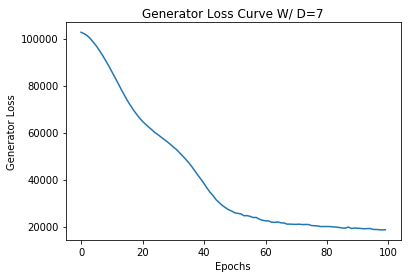

In [13]:
ax = plt.axes()
ax.plot(range(NUM_TOTAL_ITER * NUM_EPOCHS_GEN), loss_by_epoch_g)
ax.set(xlabel="Epochs", ylabel="Generator Loss", Title="Generator Loss Curve W/ D=7")

[Text(0, 0.5, 'Adversary Loss'),
 Text(0.5, 0, 'Epochs'),
 Text(0.5, 1.0, 'Adversary Loss Curve')]

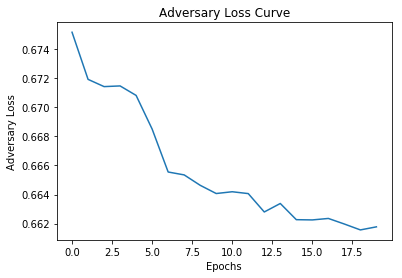

In [14]:
ax = plt.axes()
ax.plot(range(NUM_TOTAL_ITER * NUM_EPOCHS_ADV), loss_by_epoch_a)
ax.set(xlabel="Epochs", ylabel="Adversary Loss", Title="Adversary Loss Curve")

# Testing
## Test Adversary before and after decorrelation

Test the adversary to check that the decorrelation works and lowers the adversary's accuracy

In [15]:
out_class = model_adv(X_tensor.float())
v, i = torch.max(out_class, 1)
print((s_tensor.squeeze().int() == i.int()).nonzero().shape[0]/s_tensor.shape[0])

0.6125666666666667


In [16]:
gen_noised = model_gen(X_noised.float())

out_class = model_adv(gen_noised.float())
v, i = torch.max(out_class, 1)
print((s_tensor.squeeze().int() == i.int()).nonzero().shape[0]/s_tensor.shape[0])

0.6106666666666667


## Test Classifier Before and After Decorrelation

Test the classifier to see if it can still train and predict accuractely with the decorrelated data.

### Before

In [17]:
class_loader = torch.utils.data.DataLoader(
    torch.cat((X_tensor, y_tensor), 1), 
    batch_size=512, 
    shuffle=True)

for epoch in range(20):
  loss_avg = 0
  num = 0
  for batch in class_loader:
    x, y = batch[:, 0:-1], batch[:, -1]
    y_pred = model_class(x.float())

    loss = loss_class(y_pred, y.long())
    loss_avg += loss
    num += 1

    optim_class.zero_grad()
    loss.backward()
    optim_class.step()
  print("loss: ", (loss_avg/num).item())

loss:  0.6070923805236816
loss:  0.4991627037525177
loss:  0.4877968728542328
loss:  0.4851986765861511
loss:  0.48230186104774475
loss:  0.483146071434021
loss:  0.47955334186553955
loss:  0.47877004742622375
loss:  0.4770757853984833
loss:  0.47603774070739746
loss:  0.4768967926502228
loss:  0.47659870982170105
loss:  0.4746939539909363
loss:  0.4722428619861603
loss:  0.47287532687187195
loss:  0.47076284885406494
loss:  0.46613889932632446
loss:  0.46577563881874084
loss:  0.4645402133464813
loss:  0.4629393219947815


In [18]:
out_class = model_class(X_tensor_test.float())
v, i = torch.max(out_class, 1)
print((y_tensor_test.squeeze().int() == i.int()).nonzero().shape[0]/y_tensor_test.shape[0])

NameError: name 'X_tensor_test' is not defined

### After

In [ ]:
model_class = torch.nn.Sequential(
          # Layer 1 - 23 -> 512
          torch.nn.Linear(dim, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 2 - 512 -> 512
          torch.nn.Linear(SIZE_1, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 3 - 512 -> SIZE_1
          torch.nn.Linear(SIZE_1, SIZE_1),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_1),
          # Layer 4 - SIZE_1 -> SIZE_2
          torch.nn.Linear(SIZE_1, SIZE_2),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(SIZE_2),
          # Output - SIZE_2 -> 2
          torch.nn.Linear(SIZE_2, 2),
        ).to(device)

optim_class = torch.optim.Adam(model_class.parameters())
loss_class = torch.nn.CrossEntropyLoss()

gen_noised = model_gen(X_noised.float())

class_loader = torch.utils.data.DataLoader(
    torch.cat((gen_noised.float(), y_tensor.float()), 1), 
    batch_size=512, 
    shuffle=True)

for epoch in range(20):
  loss_avg = 0
  num = 0
  for batch in class_loader:
    x, y = batch[:, 0:-1], batch[:, -1]
    y_pred = model_class(x.float())

    loss = loss_class(y_pred, y.long())
    loss_avg += loss
    num += 1

    optim_class.zero_grad()
    loss.backward(retain_graph=True)
    optim_class.step()
  print("loss: ", (loss_avg/num).item())

In [ ]:
out_class = model_class(X_tensor_test.float())
v, i = torch.max(out_class, 1)
print((y_tensor_test.squeeze().int() == i.int()).nonzero().shape[0]/y_tensor_test.shape[0])